In [1]:
# code modified from here:
# https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Full-Archive-Tweet-Counts/full_archive_tweet_counts.py

import os
import json
import numpy as np
import pandas as pd
import time
import matplotlib.pylab as plt
import datetime
import seaborn as sns

In [2]:
savefig_settings = {'bbox_inches': 'tight', 'facecolor': 'w', 'dpi': 150}
idx = pd.IndexSlice
save_fig = False

In [3]:
#plt.rcParams["font.family"] = "Lato"

## check results of automatic labeling

In [4]:
tweets_classified_df = pd.read_csv("../classifier/tweets_classified2_annotated.csv", index_col=0)
print(len(tweets_classified_df))

1467983


In [5]:
# convert created_at to pd time object
def convert_str_to_datetime(datetime_string):
    return datetime.datetime.strptime(datetime_string ,"%Y-%m-%dT%H:%M:%S.%fZ")

tweets_classified_df['created_at'] = tweets_classified_df['created_at'].apply(convert_str_to_datetime)

In [6]:
# aggregate category labels

keywords_df = pd.read_csv("../data-download/Geoengineering keywords for Twitter query - review.csv", header=[1])
#keywords_df = pd.read_csv("../data-download/Geoengineering keywords for Twitter query - review_separate_ocean_alkalinization.csv", header=[1])
keywords_filtered = keywords_df[keywords_df["action after second update"] == "keep"]
subquery_ids = keywords_filtered["subquery_id"].values

for cat in keywords_filtered['category'].unique():
    print(cat)
    sids = keywords_filtered[keywords_filtered['category'] == cat]["subquery_id"].values
    tweets_classified_df[cat] = (tweets_classified_df[sids].sum(axis=1) > 0).map({True: 1, False: 0})

General
SRM
GGR


In [7]:
# exclude ccs from cdr

# get subquery ids for CCS
ccs_sids = keywords_filtered[keywords_filtered['technology_category'] == 'CCS']['subquery_id'].to_list()
print(ccs_sids)

mr_sids = keywords_filtered[keywords_filtered['technology_category'] == 'methane removal']['subquery_id'].to_list()
print(mr_sids)

ggr_sids = keywords_filtered[keywords_filtered['category'] == 'GGR']['subquery_id'].to_list()
print(ggr_sids)

cdrwoccs_sids = list(set(ggr_sids) - set(ccs_sids) - set(mr_sids))
print(cdrwoccs_sids)

tweets_classified_df["CDRwoCCS"] = (tweets_classified_df[cdrwoccs_sids].sum(axis=1) > 0).map({True: 1, False: 0})

['c_10', 'c_11', 'c_12', 'c_13', 'c_14', 'c_15', 'c_16', 'c_17']
['c_18', 'c_19', 'c_54']
['c_01', 'c_02', 'c_03', 'c_04', 'c_05', 'c_06', 'c_07', 'c_08', 'c_55', 'c_10', 'c_11', 'c_12', 'c_13', 'c_14', 'c_15', 'c_16', 'c_17', 'c_18', 'c_19', 'c_54', 'c_09', 'c_20', 'c_21', 'c_22', 'c_50', 'c_23', 'c_49', 'c_24', 'c_25', 'c_26', 'c_51', 'c_27', 'c_29', 'c_30', 'c_31', 'c_32', 'c_33', 'c_36', 'c_37', 'c_38', 'c_39', 'c_40', 'c_41', 'c_42', 'c_43', 'c_52', 'c_53', 'c_44', 'c_45', 'c_46', 'c_47', 'c_48']
['c_08', 'c_46', 'c_22', 'c_24', 'c_32', 'c_55', 'c_33', 'c_48', 'c_49', 'c_26', 'c_44', 'c_50', 'c_20', 'c_53', 'c_39', 'c_30', 'c_47', 'c_01', 'c_25', 'c_43', 'c_29', 'c_38', 'c_03', 'c_37', 'c_05', 'c_06', 'c_23', 'c_52', 'c_09', 'c_40', 'c_45', 'c_27', 'c_31', 'c_36', 'c_42', 'c_04', 'c_07', 'c_51', 'c_41', 'c_02', 'c_21']


In [8]:
# count retweets, replies, likes, quotes

filtered_df = tweets_classified_df[tweets_classified_df["CDRwoCCS"] == 1]
print(len(filtered_df))
filtered_df[['retweet_count', 'reply_count', 'like_count', 'quote_count']].sum()

471386


retweet_count    1004533
reply_count       200055
like_count       2776170
quote_count       100455
dtype: int64

In [9]:
filtered_df[['retweet_count', 'reply_count', 'like_count', 'quote_count']].sum() / len(filtered_df)

retweet_count    2.131020
reply_count      0.424397
like_count       5.889377
quote_count      0.213106
dtype: float64

## map high dimensional emotions

In [10]:
tweets_classified_df['geomotions-ekman-tertiary'] = tweets_classified_df['geomotions-ekman'].map({'neutral': 'neutral',
                                               'joy': 'positive',
                                                'surprise': 'neutral',
                                                'anger': 'negative',
                                                'fear': 'negative',
                                                'sadness': 'negative',
                                                'disgust': 'negative'})

In [11]:
tweets_classified_df['cardiff-emotion-tertiary'] = tweets_classified_df['cardiff-emotion'].map({
'optimism': 'neutral',
'anger': 'negative',
'sadness': 'negative',
'joy': 'positive'
})

In [12]:
tweets_classified_df["nrc-highest-tertiary"] = tweets_classified_df["nrc-highest"].map({
'neutral': 'neutral',
'positive': 'positive',
'negative': 'negative',
'fear': 'negative',
'trust': 'positive',
'anger': 'negative',
'anticipation': 'positive',
'surprise': 'neutral',
'sadness': 'negative',
'disgust': 'negative',
'joy': 'positive'
})

In [13]:
tweets_classified_df["bertweet-emotions-tertiary"] = tweets_classified_df["bertweet-emotions"].map({
'others': 'neutral',
'disgust': 'negative',
'joy': 'positive',
'fear': 'negative',
'anger': 'negative',
'surprise': 'neutral',
'sadness': 'negative'})

## plot counts by subquery or category

In [14]:
# how many are in more than one category

sid_counts = tweets_classified_df[subquery_ids].sum(axis=1).value_counts()
print(sid_counts.sum())
sid_counts

1467983


1     1356283
2      100019
3        9427
4        1742
5         348
6          87
7          38
8          10
10         10
9           7
12          7
11          4
13          1
dtype: int64

In [15]:
print(sid_counts.sum() - sid_counts[1])
print((sid_counts.sum() - sid_counts[1])/sid_counts.sum())

111700
0.0760907994166145


In [16]:
cat_level = 'technology_category' #'technology_category' 

map_dict = {}

map_dict_reverse = {}

for cat in keywords_filtered[cat_level].unique():
    sids = keywords_filtered[keywords_filtered[cat_level] == cat]["subquery_id"].values
    map_dict[cat] = list(sids)
    for sid in sids:
        map_dict_reverse[sid] = cat

#print(json.dumps(map_dict))
#print(json.dumps(map_dict_reverse))

In [17]:
count_tweets = tweets_classified_df[subquery_ids].sum()

count_dict = {}

for cl in map_dict:
    count_dict[cl] = count_tweets[map_dict[cl]].sum()
#print(count_dict)

In [18]:
print(len(count_dict))
count_df = pd.Series(count_dict).to_frame()
count_df['pct_of_total'] = 100*count_df[0] / count_df[0].sum()
count_df = count_df.rename(columns={0: "# tweets"})

19


In [19]:
# retweets, replies, likes and quotes by technology

cat_level = 'technology_category'

for count_type in ['retweet_count', 'reply_count', 'like_count', 'quote_count']:

    value_counts = {}
    for cat in keywords_filtered[cat_level].unique():
        sids = keywords_filtered[keywords_filtered[cat_level] == cat]["subquery_id"].values
        #print(cat, sids)
    
        value_counts[cat] = tweets_classified_df[tweets_classified_df[sids].sum(axis=1) > 0][count_type].sum()
        
    count_df[count_type] = pd.Series(value_counts)

In [20]:
# check tweet numbers

value_counts = {}
for cat in keywords_filtered[cat_level].unique():
    sids = keywords_filtered[keywords_filtered[cat_level] == cat]["subquery_id"].values
    value_counts[cat] = tweets_classified_df[tweets_classified_df[sids].sum(axis=1) > 0]['tid'].count()
    
count_df['tweet_count'] = pd.Series(value_counts)
count_df['tweet_share'] = count_df['tweet_count'] / count_df['tweet_count'].sum()

In [21]:
count_df['rt_per_tweet'] = count_df['retweet_count'] / count_df['tweet_count']
count_df['reply_per_tweet'] = count_df['reply_count'] / count_df['tweet_count']
count_df['like_per_tweet'] = count_df['like_count'] / count_df['tweet_count']
count_df['quote_per_tweet'] = count_df['quote_count'] / count_df['tweet_count']

In [22]:
#count_df.to_csv('tweet_counts_shares_multipliers_19cats.csv')

## Relative tweets compared to total twitter

In [23]:
# import total tweet count estimates
en_counts = pd.read_csv("../data-download/tweet-counts/english_tweet_counts_daily_2006-2021-rt.csv", parse_dates=[0])
en_counts_yr = en_counts.groupby(pd.Grouper(key="start",freq='Y')).sum()

In [24]:
geoeng_counts_yr = tweets_classified_df.groupby(pd.Grouper(key="created_at",freq='Y'))['tid'].count()

In [25]:
counts_yr = pd.merge(en_counts_yr, geoeng_counts_yr, left_index=True, right_index=True).rename(columns={'tweet_count': 'english_tweets', 'tid': 'geoengin_tweets'})

In [26]:
counts_yr['pct_share'] = 100*counts_yr['geoengin_tweets'] / counts_yr['english_tweets']
counts_yr['inv_ratio'] = counts_yr['english_tweets'] / counts_yr['geoengin_tweets']
counts_yr

english_tweets  geoengin_tweets  pct_share      inv_ratio
2007-12-31        15871648               29   0.000183  547298.206897
2008-12-31       121295075              475   0.000392  255358.052632
2009-12-31      1928254165            14366   0.000745  134223.455729
2010-12-31      5212755460            29353   0.000563  177588.507478
2011-12-31     12132471539            37599   0.000310  322680.697332
2012-12-31     21606388875            68578   0.000317  315062.977558
2013-12-31     21734849313            79144   0.000364  274624.094221
2014-12-31     17615741041           123148   0.000699  143045.287305
2015-12-31     13870588291           157870   0.001138   87860.824039
2016-12-31     11770855470           140872   0.001197   83557.097720
2017-12-31      9902670320           147125   0.001486   67307.869635
2018-12-31      8820717113           152034   0.001724   58018.055915
2019-12-31      9634363038           173661   0.001803   55477.988944
2020-12-31     13680900317           131278   0.000960  104213.198838
2021-12-31     14633868905           212451   0.001452   68881.148618

In [27]:
counts_yr.iloc[:8].mean()

english_tweets     1.004595e+10
geoengin_tweets    4.408650e+04
pct_share          4.466203e-04
inv_ratio          2.712352e+05
dtype: float64

In [28]:
counts_yr.iloc[8:].mean()

english_tweets     1.175914e+10
geoengin_tweets    1.593273e+05
pct_share          1.394018e-03
inv_ratio          7.504517e+04
dtype: float64

In [29]:
1.39e-3 / 4.466e-4

3.1124048365427672

In [30]:
2.712352e+05 / 7.504517e+04

3.6142925653976135

## plot label counts by category

In [31]:
# counts by category

cat_level = 'technology_category' #  'category' or 'technology_category' or 'subquery_id'

value_counts = {}
all_class_counts = {}
all_class_shares = {}

for classifier_name in ['cardiff-sentiment', 'bertweet-sentiment', 'nrc-highest-tertiary',
'cardiff-emotion-tertiary', 'geomotions-ekman-tertiary', 'bertweet-emotions-tertiary', 'conspiracy-filter']:
    
    print(classifier_name)
    for cat in keywords_filtered[cat_level].unique():
        sids = keywords_filtered[keywords_filtered[cat_level] == cat]["subquery_id"].values
        #print(cat, sids)
        value_counts[cat] = tweets_classified_df[tweets_classified_df[sids].sum(axis=1) > 0][classifier_name].value_counts()

    class_counts = pd.DataFrame(value_counts).sort_index()
    all_class_counts[classifier_name] = class_counts
    
    class_shares = 100 * (class_counts / class_counts.sum())
    all_class_shares[classifier_name] = class_shares
    
all_class_counts = pd.concat(all_class_counts)
all_class_shares = pd.concat(all_class_shares)

cardiff-sentiment
bertweet-sentiment
nrc-highest-tertiary
cardiff-emotion-tertiary
geomotions-ekman-tertiary
bertweet-emotions-tertiary
conspiracy-filter


In [32]:
#all_class_shares

In [38]:
keywords_filtered['technology_category'].unique()

array(['Geoengineering (general)', 'SRM (general)', 'aerosol injection',
       'cloud brightening', 'surface albedo modification',
       'cloud thinning', 'space shades', 'GGR (general)', 'CCS',
       'methane removal', 'ocean fertilization', 'enhanced weathering',
       'biochar', 'afforestation and reforestation',
       'ecosystem restoration', 'Soil carbon sequestration', 'BECCS',
       'blue carbon', 'direct air capture'], dtype=object)

In [33]:
save_fig = False

In [50]:
rename_dict = {'ocean fertilization': 'Ocean fertilization',
                  'enhanced weathering': 'Enhanced weathering',
                  'biochar': 'Biochar',
                  'afforestation and reforestation': 'Afforestation and reforestation',
                  'ecosystem restoration': 'Ecosystem restoration',
                  'blue carbon': 'Blue carbon management',
                   'ocean alkalinization': 'Ocean alkalinization',
                  'direct air capture': 'Direct air capture',
                  'GGR (general)': 'GGR (general)',
                  'aerosol injection': 'Stratospheric aerosol injection',
                  'cloud brightening': 'Cloud brightening',
                'surface albedo modification': 'Surface albedo modification',
                  'cloud thinning': 'Cloud thinning',
               'space shades': 'Space shades',
              'methane removal': 'Methane removal'}

## plot tweet counts per category over time

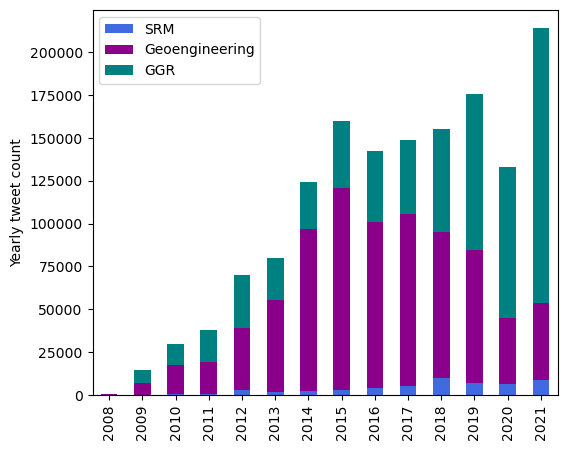

In [96]:
# group by year

fig, ax = plt.subplots(figsize=(6,5)) # figsize for poster: 
# linewidth
lw = 2
# by category
monthly_count = tweets_classified_df.groupby(pd.Grouper(key='created_at', freq='Y'))[["General", "SRM", "GGR"]].sum()
#monthly_count.plot.area(stacked=True, ax=ax)

monthly_count[["SRM", "General", "GGR"]].plot.bar(ax=ax, stacked=True,
                                                  color=["royalblue", "darkmagenta", "teal"],
                                                  linewidth=lw, legend='reverse')
# all
#monthly_count = tweets_classified_df.groupby(pd.Grouper(key='created_at', freq='Y'))['tid'].count()
#monthly_count.plot(ax=ax, color='k', label='total', linewidth=lw)
plt.legend(['SRM', 'Geoengineering', 'GGR'])
ax.set_ylabel('Yearly tweet count')
ax.set_xlabel('')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(range(2007, 2022))
ax.set_xlim([0.5,14.5])
if save_fig:
    fig.savefig("figures/timeseries_yearly_category_bar_CDR.png", **savefig_settings)
    fig.savefig("figures/timeseries_yearly_category_bar_CDR.svg", **savefig_settings)

In [68]:
# relevant events

events = [
    {'name': 'COP18 Doha', 'date': [datetime.date(2012, 11, 26), datetime.date(2012, 12, 8)]},
    {'name': 'COP19 Warsaw', 'date': [datetime.date(2013, 11, 11), datetime.date(2013, 11, 23)]},
    {'name': 'COP20 Lima', 'date': [datetime.date(2014, 12, 1), datetime.date(2014, 12, 12)]},
    {'name': 'COP21 Paris', 'date': [datetime.date(2015, 11, 30), datetime.date(2015, 12, 12)]},
    {'name': 'COP22 Marrakech', 'date': [datetime.date(2016, 11, 7), datetime.date(2016, 11, 18)]},
#    'Hurricane Harvey': datetime.date(year=2017, month=8, day=17),
    {'name': 'COP23 Bonn', 'date': [datetime.date(2017, 11, 6), datetime.date(2017, 11, 17)]},
    {'name': 'SR15 release', 'date': datetime.date(2018, 10, 8)},
    {'name': 'COP24 Katowice', 'date': [datetime.date(2018, 12, 2), datetime.date(2018, 12, 15)],
     'align': 'left', 'voffset': 30},
    {'name': 'UN Climate action summit', 'date': datetime.date(2019, 9, 23)},
    {'name': 'COP25 Madrid', 'date': [datetime.date(2019, 12, 2), datetime.date(2019, 12, 13)],
    'voffset': 10},
    {'name': 'Covid-19 pandemic declared', 'date': datetime.date(2020, 3, 11)},
    {'name': 'AR6 WGI release', 'date': datetime.date(2021, 8, 9)},
#    'Australian Bushfires': datetime.date(year=2019, month=9, day=1), # out-of-control fires sprung up
    {'name': 'COP26 Glasgow', 'date': [datetime.date(2021, 10, 31), datetime.date(2021, 11, 13)]}
]

for event in events:
    print(event['name'], event['date'])
    
# routine to plot events
from matplotlib.patches import Rectangle
from matplotlib.dates import num2date

def plot_events(ax, ymin, ymax, color = 'grey', lw=2):
    
    xlim_min, xlim_max = ax.get_xlim()
    #print(xlim_min, xlim_max)
    xlim_min = num2date(xlim_min)
    xlim_max = num2date(xlim_max)
    #print(xlim_min, xlim_max)
    
    for ev in events:
        if not isinstance(ev['date'], list):
            ax.axvline(ev['date'], ymin, ymax, color=color, lw=lw)
            xmin = ev['date']
            xmax = ev['date'] + datetime.timedelta(days=1)
        elif len(ev['date']) == 2:
            xmin, xmax = ev['date']
            ax.add_patch(Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   facecolor=color,
                                   edgecolor=color,
                                   lw=lw
                                  ))
        else:
            continue

        if 'align' in ev.keys():
            align = ev['align']
            x_label = xmax
        else:
            align = 'right'
            x_label = xmin
            
        if 'voffset' in ev.keys():
            x_label += ev['voffset']*datetime.timedelta(days=1)
            
        if (xlim_min.date() <= x_label) and (x_label <= xlim_max.date()):

            ax.text(x_label,ymax - (ymax-ymin)/50,
                 ev['name'],rotation=90, fontsize=9, va='top', ha=align)

COP18 Doha [datetime.date(2012, 11, 26), datetime.date(2012, 12, 8)]
COP19 Warsaw [datetime.date(2013, 11, 11), datetime.date(2013, 11, 23)]
COP20 Lima [datetime.date(2014, 12, 1), datetime.date(2014, 12, 12)]
COP21 Paris [datetime.date(2015, 11, 30), datetime.date(2015, 12, 12)]
COP22 Marrakech [datetime.date(2016, 11, 7), datetime.date(2016, 11, 18)]
COP23 Bonn [datetime.date(2017, 11, 6), datetime.date(2017, 11, 17)]
SR15 release 2018-10-08
COP24 Katowice [datetime.date(2018, 12, 2), datetime.date(2018, 12, 15)]
UN Climate action summit 2019-09-23
COP25 Madrid [datetime.date(2019, 12, 2), datetime.date(2019, 12, 13)]
Covid-19 pandemic declared 2020-03-11
AR6 WGI release 2021-08-09
COP26 Glasgow [datetime.date(2021, 10, 31), datetime.date(2021, 11, 13)]


In [69]:
#save_fig=True

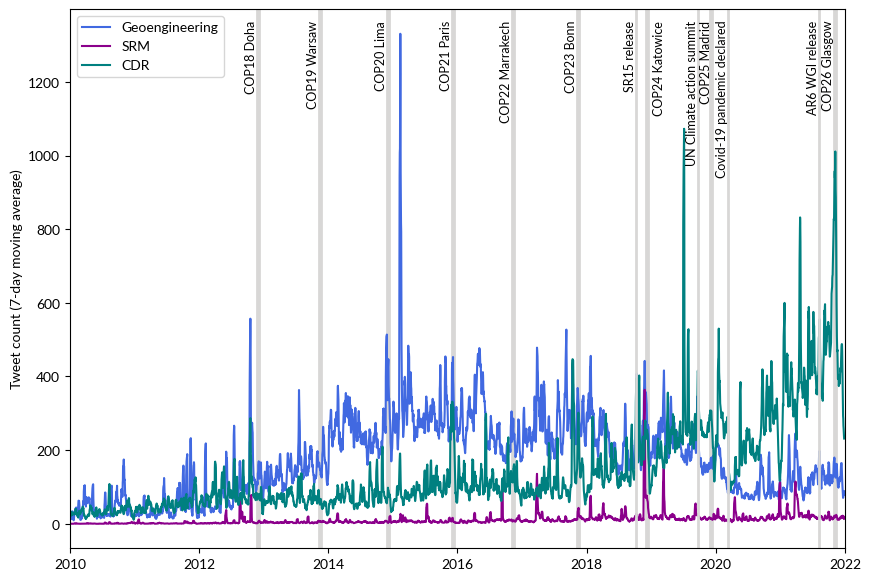

In [70]:
# 7-day moving average

fig, ax = plt.subplots(figsize=(10,7))

# all
#daily_count = tweets_classified_df.groupby(by=tweets_classified_df['created_at'].dt.date)['tid'].count()
# by category
daily_count = tweets_classified_df.groupby(by=tweets_classified_df['created_at'].dt.date)[["General", "SRM", "GGR"]].sum()

rolling_avg = daily_count.rolling(7, center=True).mean()
rolling_avg.plot(ax=ax, color=["royalblue", "darkmagenta", "teal"])

ax.set_ylabel('Tweet count (7-day moving average)')
plt.legend(['Geoengineering', 'SRM', 'CDR'])


ymin, ymax = ax.get_ylim()
custom_grey = [217/ 256, 216/ 256, 215/ 256] 
plot_events(ax, ymin, ymax, color=custom_grey)

ax.set_xlim([datetime.datetime(2010, 1, 1), datetime.datetime(2022, 1, 1)])

ax.set_ylim([ymin, ymax])

ax.set_xlabel('')

# add marker for pandemic
#pandemic_onset = datetime.date(2020, 3, 11)
#ax.add_patch(Rectangle((pandemic_onset, 0), datetime.timedelta(days=730), 50,
#                       facecolor='darkred',lw=0))

#ax.text((x_label-datetime.timedelta(days=0)),ymax - (ymax-ymin)/50,
#                 'Covid',rotation=90, fontsize=9, va='top', ha='right')

if save_fig:
    fig.savefig("figures/7-day_moving_avg_all.png", **savefig_settings)
    fig.savefig("figures/7-day_moving_avg_all.svg", **savefig_settings)
    
#daily_count.to_csv('figures/timeseries_daily_count_geoeng.csv')

## plot tweet counts per technology_category over time

In [44]:
save_fig = False

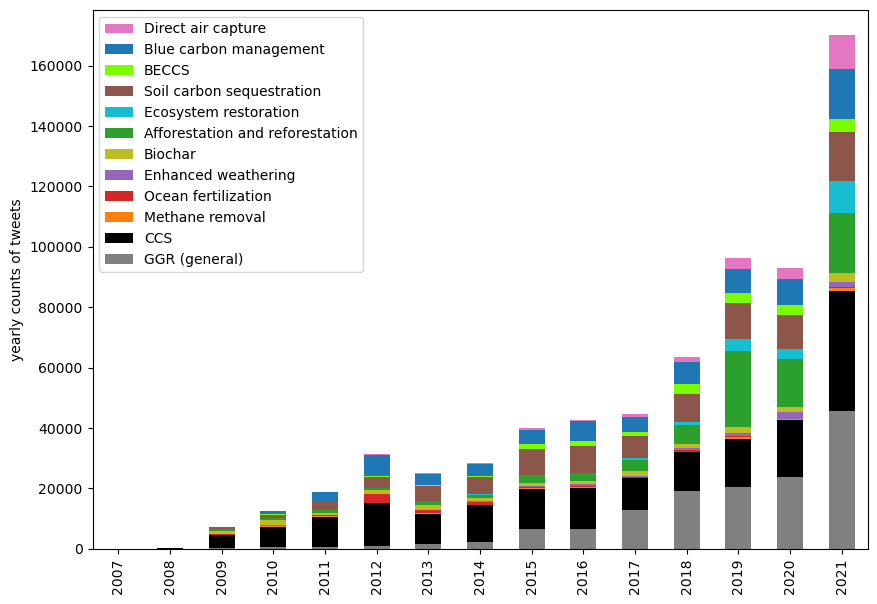

In [65]:
# group by year and technology category

category_filter = "GGR"

frequency = 'Y' # 'M'
frequency_name = 'yearly' # 'monthly'

filtered_df = tweets_classified_df[tweets_classified_df[category_filter] == 1]

all_classes_ts = {}

for cat in keywords_filtered[keywords_filtered['category'] == category_filter]['technology_category'].unique():
    sids = keywords_filtered[keywords_filtered['technology_category'] == cat]["subquery_id"].values

    all_classes_ts[cat] = filtered_df[filtered_df[sids].sum(axis=1) > 0].groupby(pd.Grouper(key='created_at',
                                                                                            freq=frequency)).size()
    
all_classes_df = pd.concat(all_classes_ts, axis=1).sort_index().fillna(0)

cdr_colors = ["grey", 'k', "tab:orange", "tab:red", "tab:purple", "tab:olive",
          "tab:green", "tab:cyan", "tab:brown", "lawngreen", "tab:blue", "tab:pink"]

#all_classes_df = all_classes_df.rename(columns={'GGR (general)': 'CDR (general)'}).drop(['CCS', 'methane removal'], axis=1)

all_classes_df.rename(columns=rename_dict, inplace=True)

# bar plot of counts

all_classes_df.index = all_classes_df.index.year

fig, ax = plt.subplots(figsize=(10,7))
all_classes_df.plot.bar(ax=ax, stacked=True, legend='reverse', color=cdr_colors)
ax.set_ylabel("{} counts of tweets".format(frequency_name))
ax.set_xlabel("")

if save_fig:
    fig.savefig("figures/timeseries/subsets/timeseries_{}_counts_GGR_bar_new.png".format(frequency_name), **savefig_settings)

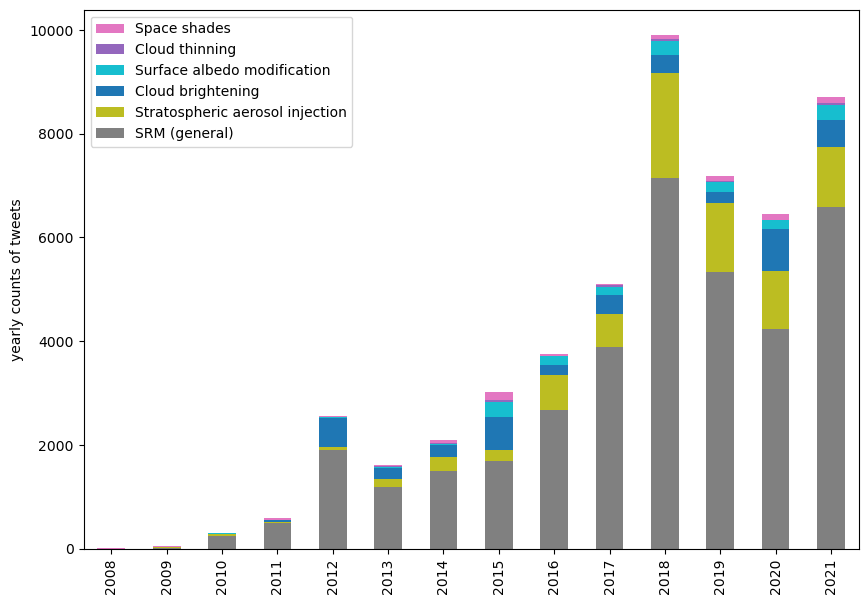

In [71]:
# group by year and technology category

category_filter = "SRM"

frequency = 'Y' # 'M'
frequency_name = 'yearly' # 'monthly'

filtered_df = tweets_classified_df[tweets_classified_df[category_filter] == 1]

all_classes_ts = {}

for cat in keywords_filtered[keywords_filtered['category'] == category_filter]['technology_category'].unique():
    sids = keywords_filtered[keywords_filtered['technology_category'] == cat]["subquery_id"].values

    all_classes_ts[cat] = filtered_df[filtered_df[sids].sum(axis=1) > 0].groupby(pd.Grouper(key='created_at',
                                                                                            freq=frequency)).size()
    
all_classes_srm = pd.concat(all_classes_ts, axis=1).sort_index().fillna(0)

srm_colors = ["grey", "tab:olive", "tab:blue", "tab:cyan" , "tab:purple", "tab:pink"]

#all_classes_df = all_classes_df.rename(columns={'GGR (general)': 'CDR (general)'}).drop(['CCS', 'methane removal'], axis=1)

all_classes_srm.rename(columns=rename_dict, inplace=True)

# bar plot of counts

all_classes_srm.index = all_classes_srm.index.year

fig, ax = plt.subplots(figsize=(10,7))
all_classes_srm.plot.bar(ax=ax, stacked=True, legend='reverse', color=srm_colors)
ax.set_ylabel("{} counts of tweets".format(frequency_name))
ax.set_xlabel("")

if save_fig:
    fig.savefig("figures/timeseries/subsets/timeseries_{}_counts_SRM_bar_new.png".format(frequency_name), **savefig_settings)

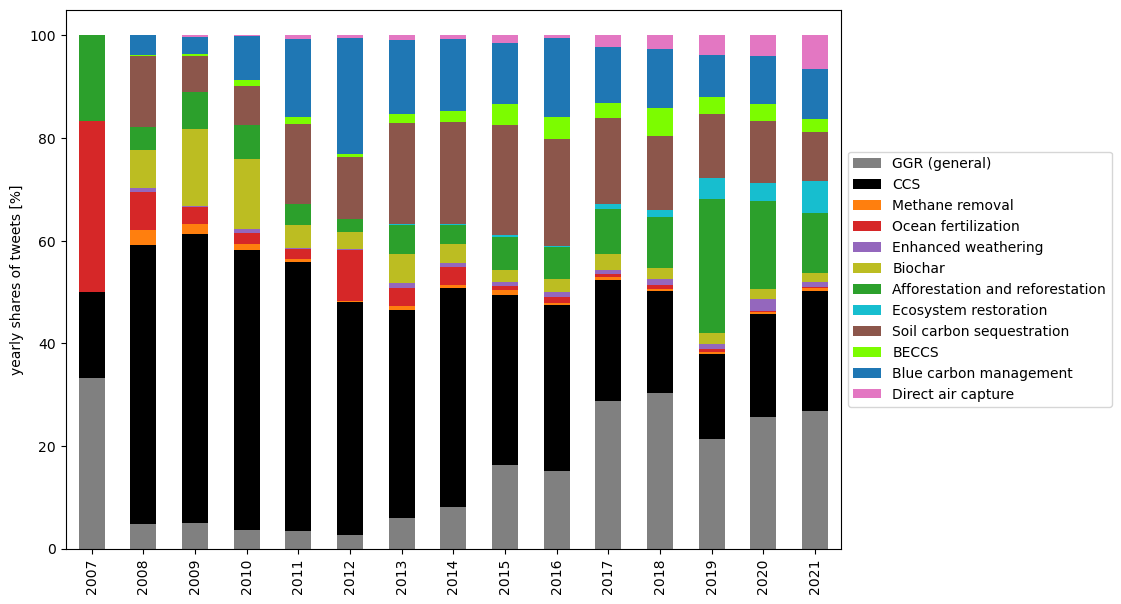

In [72]:
# bar plot of shares

shares_df = 100 * all_classes_df.divide(all_classes_df.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(10,7))    
shares_df.plot.bar(ax=ax, stacked=True, legend='reverse', color=cdr_colors)
ax.set_ylabel("{} shares of tweets [%]".format(frequency_name))
ax.set_xlabel("")

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

if save_fig:
    fig.savefig("figures/timeseries/subsets/timeseries_{}_shares_CDR_woCCS_bar.png".format(frequency_name), **savefig_settings)

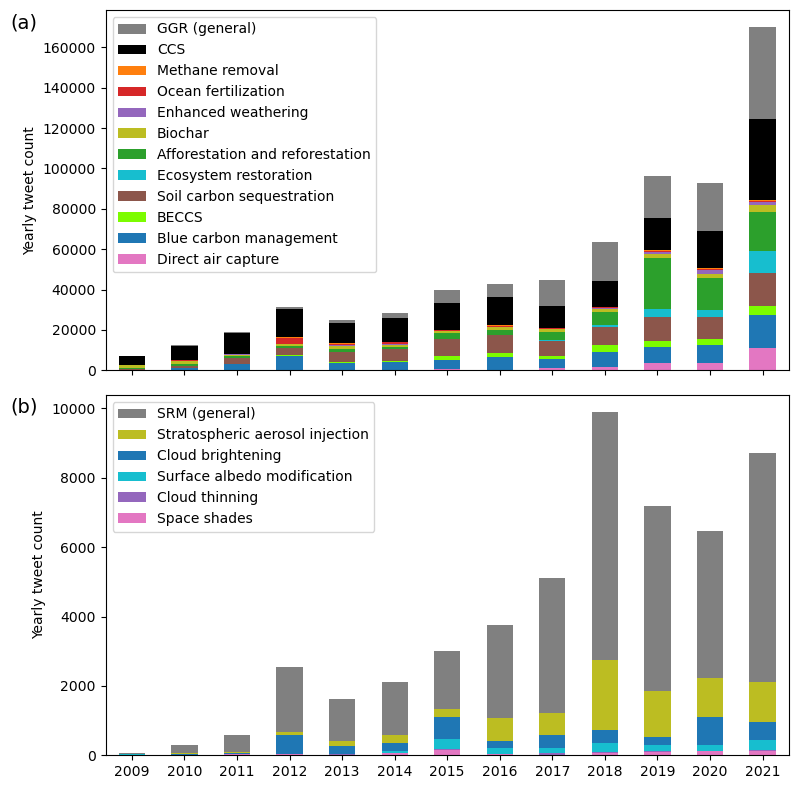

In [81]:
# combine GGR and SRM in one figure

fig, ax = plt.subplots(2, 1, figsize=(8,8), sharex=True)

all_classes_filtered = all_classes_df.drop([2007, 2008]).iloc[:, ::-1]

all_classes_filtered.plot.bar(ax=ax[0], stacked=True, legend='reverse', color=cdr_colors[::-1])
ax[0].set_ylabel("Yearly tweet count".format(frequency_name))
ax[0].set_xlabel("")

# add comma for format
#import matplotlib as mpl
#ax[0].get_yaxis().set_major_formatter(
#    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

all_classes_filtered = all_classes_srm.drop([2008]).iloc[:, ::-1]

all_classes_filtered.plot.bar(ax=ax[1], stacked=True, legend='reverse', color=srm_colors[::-1])
ax[1].set_ylabel("Yearly tweet count".format(frequency_name))
ax[1].set_xlabel("")

for i, l in enumerate(['(a)', '(b)']):
    ax[i].text(-0.14, 0.95, l, fontsize=14, transform=ax[i].transAxes)


ax[1].set_xticklabels(np.arange(2009, 2022), rotation = 0)

fig.tight_layout()

if save_fig:
    fig.savefig("figures/all_timeseries_counts_bars.png", **savefig_settings)
    #fig.savefig("figures/all_timeseries_counts_bars.svg", **savefig_settings)

In [117]:
save_fig = True

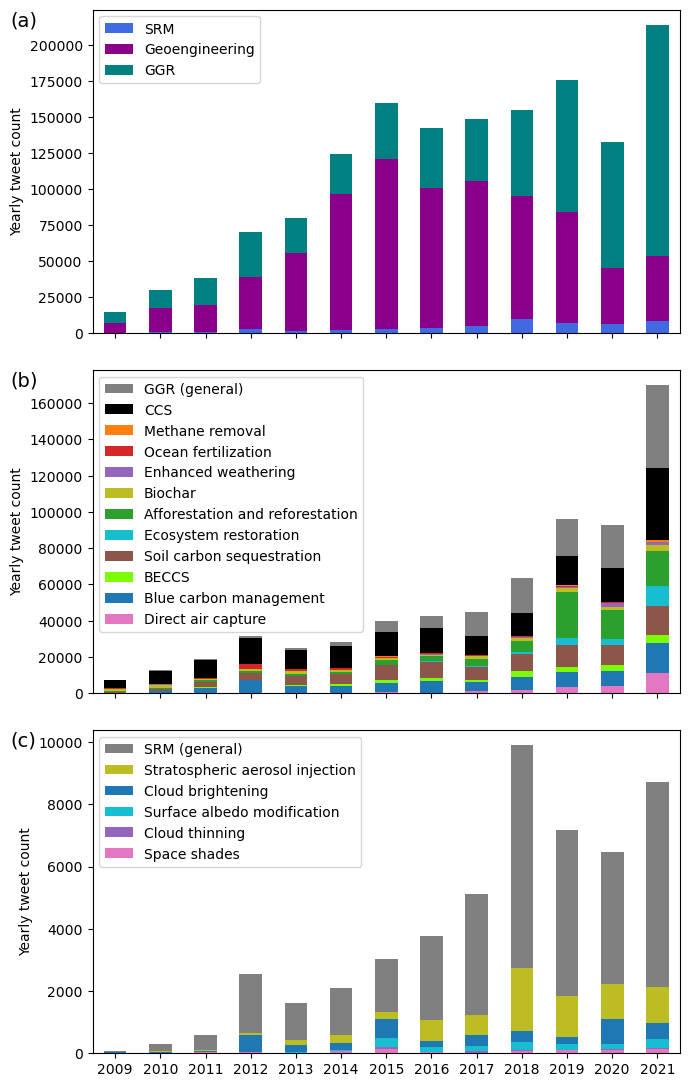

In [118]:
# combine overview, GGR and SRM in one figure

fig, ax = plt.subplots(3, 1, figsize=(7,11), sharex=True) #, gridspec_kw={'wspace': 0.1})


yr_count = tweets_classified_df.groupby(pd.Grouper(key='created_at', freq='Y'))[["General", "SRM", "GGR"]].sum()

yr_count = yr_count.iloc[2:]
yr_count[["SRM", "General", "GGR"]].plot.bar(ax=ax[0], stacked=True,
                                                  color=["royalblue", "darkmagenta", "teal"],
                                                  legend='reverse')

ax[0].legend(['SRM', 'Geoengineering', 'GGR'])
ax[0].set_ylabel('Yearly tweet count')
#ax[0].set_ylim([0,180000])

all_classes_filtered = all_classes_df.drop([2007, 2008]).iloc[:, ::-1]

all_classes_filtered.plot.bar(ax=ax[1], stacked=True, legend='reverse', color=cdr_colors[::-1])
ax[1].set_ylabel("Yearly tweet count".format(frequency_name))
ax[1].set_xlabel("")

# add comma for format
#import matplotlib as mpl
#ax[0].get_yaxis().set_major_formatter(
#    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

all_classes_filtered = all_classes_srm.drop([2008]).iloc[:, ::-1]

all_classes_filtered.plot.bar(ax=ax[2], stacked=True, legend='reverse', color=srm_colors[::-1])
ax[2].set_ylabel("Yearly tweet count".format(frequency_name))
ax[2].set_xlabel("")

for i, l in enumerate(['(a)', '(b)', '(c)']):
    ax[i].text(-0.14, 0.95, l, fontsize=14, transform=ax[i].transAxes)


ax[2].set_xticklabels(np.arange(2009, 2022), rotation = 0)

#plt.subplots_adjust(wspace=0.01)

fig.tight_layout()

if save_fig:
    fig.savefig("figures/all_timeseries_counts_bars.png", **savefig_settings)
    fig.savefig("figures/all_timeseries_counts_bars.svg", **savefig_settings)